In [1]:
'''
re                - to remove english letters in dataset
string            - to remove punctuations
numpy             - basic array operations
pandas            - to manage DataFrames
itertools groupby - to remove consecutive duplicates
'''
import re
import string
import random
import numpy as np
import pandas as pd
from itertools import groupby

#to join paths, list directories in the dataset
import os
from os import listdir

#to load images
from PIL import Image

#to save and load pickle files
from pickle import load
from pickle import dump

#to plot loaded images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

'''
tensorflow                           - for all model trainings, preprocessings, etc
Input                                - for input layer
to_categorical                       - to encode text sequences
Model, load_model                    - to work with any model or load a saved model
pad_sequences                        - to pad text sequences with zeros
load_img, img_to_array               - as the name suggests
Dropout, Embedding, LSTM, Dense, Add - various layers
preprocess_input, InceptionV3        - The InceptionV3 model itself and a preprocessing library for the model
'''
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dropout, Embedding, LSTM, Dense, Add
from tensorflow.keras.applications.inception_v3 import preprocess_input, InceptionV3

#to handle an error while training the final model
tf.config.run_functions_eagerly(True)

In [2]:
captions_dir = 'data/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8kTelugu.token.txt'
train_images_dir = 'data/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
descriptions_dir = 'descriptions.txt'
images_dir = 'data/Flickr_Data/Flickr_Data/Images/'
embeddings_dir = 'Word Embeddings/cc.te.300.vec.txt'
embedding_dim = 300
train_images_pkl_dir = 'Pickle Encodings/second_encoded_train_images.pkl'
models_dir = 'Models/'
test_img_dir = 'data/Flickr_Data/Flickr_Data/Images/1075867198_27ca2e7efe.jpg'
test_model_dir = 'Models/model_199.h5'
start_token = 'Start '
end_token = ' End'

In [3]:
#function to load an read a text file
def load_doc(filename):
    
    #opening the file as read only
    file = open(filename, 'r')
    
    #reading all text
    text = file.read()
    
    #closeing the file
    file.close()
    
    return text

In [4]:
#All the image names and captions are stored in descriptions
descriptions = dict()

#reading the file
doc = load_doc(captions_dir)

#iterating through the lines
for line in doc.split('\n'):
    
    #seperating id and captions
    tokens = line.split('\t')
    image_id, image_desc = tokens[0], tokens[1:]
    
    image_id = image_id.split('.')[0]
    image_desc = ' '.join(image_desc)
    
    #adding to the descriptions dictionaty
    if image_id not in descriptions:
        descriptions[image_id] = list()
    
    descriptions[image_id].append(image_desc)

In [5]:
#checking
descriptions['1000268201_693b08cb0e']

['గులాబీ రంగు దుస్తులు ధరించిన పిల్లవాడు ప్రవేశ మార్గంలో ఒక మెట్ల పైకి ఎక్కుతున్నాడు.',
 'ఒక చెక్క భవనంలోకి వెళుతున్న అమ్మాయి.',
 'ఒక చిన్న అమ్మాయి చెక్క ప్లేహౌస్ పైకి ఎక్కడం.',
 'ఒక చిన్న అమ్మాయి తన ప్లేహౌస్కు మెట్లు ఎక్కేది.',
 'గులాబీ రంగు దుస్తులు ధరించిన ఒక చిన్న అమ్మాయి చెక్క క్యాబిన్లోకి వెళుతుంది.']

In [6]:
#checking total images
len(descriptions)

8093

In [7]:
#function to save the descriptions to a text file
def save_descriptions(descriptions, filename):
    
    lines = list()
    
    #iterating through the items
    for key, desc_list in descriptions.items():
        
        #iterating through the captions
        for desc in desc_list:
            
            #appending
            lines.append(key + ' ' + desc)
    
    #joining
    data = '\n'.join(lines)
    
    #file handling
    file = open(filename, 'w')
    file.write(data)
    file.close()

#saving descriptions
save_descriptions(descriptions, descriptions_dir)

In [8]:
#cleaning the captions
table = str.maketrans('', '', string.punctuation)

#iterating through all items
for key, desc_list in descriptions.items():
    
    #iterating through captions of each image
    for i in range(len(desc_list)):
        
        #getting ith caption
        desc = desc_list[i]
        
        #tokenizing
        desc = desc.split()
        
        #removing punctuation from each token
        desc = [w.translate(table) for w in desc]
        
        #removing \u200c
        #\u200c is a seperator generated during translation
        desc = [' '.join(word.split('\u200c')) for word in desc]
        
        #removing english letters generated during translation
        desc = [word for word in desc if not re.match(r'[A-Z]+', word, re.I)]
        
        #putting back the caption
        desc_list[i] =  ' '.join(desc)

In [9]:
#generating all train images list
train = list()

#reading the file
doc = load_doc(train_images_dir)

#iterating through the lines
for line in doc.split('\n'):
    
    #skipping empty lines
    if len(line) < 1:
        continue
    
    #appending the image id
    identifier = line.split('.')[0]
    train.append(identifier)

print('Dataset: %d' % len(train))

Dataset: 6000


In [10]:
#generating train descriptions
train_descriptions = dict()

#loading descriptions
doc = load_doc(descriptions_dir)

#making set of train images
dataset = set(train)

#iterating through descriptions
for line in doc.split('\n'):
    
    #splitting line by white space
    tokens = line.split()
    
    #try splitting id from captions else skip
    try:
        image_id, image_desc = tokens[0], tokens[1:]
    except:
        continue
    
    #skipping images if not in the train set
    if image_id in dataset:
        
        #initiating an entry if image is for the first time
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        
        #wrapping description in tokens
        desc = start_token + ' '.join(image_desc) + end_token
        
        #storing
        train_descriptions[image_id].append(desc)

        print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=1
Descriptions: train=1
Descriptions: train=1
Descriptions: train=1
Descriptions: train=1
Descriptions: train=2
Descriptions: train=2
Descriptions: train=2
Descriptions: train=2
Descriptions: train=2
Descriptions: train=3
Descriptions: train=3
Descriptions: train=3
Descriptions: train=3
Descriptions: train=3
Descriptions: train=4
Descriptions: train=4
Descriptions: train=4
Descriptions: train=4
Descriptions: train=4
Descriptions: train=5
Descriptions: train=5
Descriptions: train=5
Descriptions: train=5
Descriptions: train=5
Descriptions: train=6
Descriptions: train=6
Descriptions: train=6
Descriptions: train=6
Descriptions: train=6
Descriptions: train=7
Descriptions: train=7
Descriptions: train=7
Descriptions: train=7
Descriptions: train=7
Descriptions: train=8
Descriptions: train=8
Descriptions: train=8
Descriptions: train=8
Descriptions: train=8
Descriptions: train=9
Descriptions: train=9
Descriptions: train=9
Descriptions: train=9
Descriptions: train=9
Descriptio

Descriptions: train=287
Descriptions: train=287
Descriptions: train=287
Descriptions: train=288
Descriptions: train=288
Descriptions: train=288
Descriptions: train=288
Descriptions: train=288
Descriptions: train=289
Descriptions: train=289
Descriptions: train=289
Descriptions: train=289
Descriptions: train=289
Descriptions: train=290
Descriptions: train=290
Descriptions: train=290
Descriptions: train=290
Descriptions: train=290
Descriptions: train=291
Descriptions: train=291
Descriptions: train=291
Descriptions: train=291
Descriptions: train=291
Descriptions: train=292
Descriptions: train=292
Descriptions: train=292
Descriptions: train=292
Descriptions: train=292
Descriptions: train=293
Descriptions: train=293
Descriptions: train=293
Descriptions: train=293
Descriptions: train=293
Descriptions: train=294
Descriptions: train=294
Descriptions: train=294
Descriptions: train=294
Descriptions: train=294
Descriptions: train=295
Descriptions: train=295
Descriptions: train=295
Descriptions: tr

Descriptions: train=387
Descriptions: train=387
Descriptions: train=387
Descriptions: train=388
Descriptions: train=388
Descriptions: train=388
Descriptions: train=388
Descriptions: train=388
Descriptions: train=389
Descriptions: train=389
Descriptions: train=389
Descriptions: train=389
Descriptions: train=389
Descriptions: train=390
Descriptions: train=390
Descriptions: train=390
Descriptions: train=390
Descriptions: train=390
Descriptions: train=391
Descriptions: train=391
Descriptions: train=391
Descriptions: train=391
Descriptions: train=391
Descriptions: train=392
Descriptions: train=392
Descriptions: train=392
Descriptions: train=392
Descriptions: train=392
Descriptions: train=393
Descriptions: train=393
Descriptions: train=393
Descriptions: train=393
Descriptions: train=393
Descriptions: train=394
Descriptions: train=394
Descriptions: train=394
Descriptions: train=394
Descriptions: train=394
Descriptions: train=395
Descriptions: train=395
Descriptions: train=395
Descriptions: tr

Descriptions: train=634
Descriptions: train=634
Descriptions: train=634
Descriptions: train=634
Descriptions: train=635
Descriptions: train=635
Descriptions: train=635
Descriptions: train=635
Descriptions: train=635
Descriptions: train=636
Descriptions: train=636
Descriptions: train=636
Descriptions: train=636
Descriptions: train=636
Descriptions: train=637
Descriptions: train=637
Descriptions: train=637
Descriptions: train=637
Descriptions: train=637
Descriptions: train=638
Descriptions: train=638
Descriptions: train=638
Descriptions: train=638
Descriptions: train=638
Descriptions: train=639
Descriptions: train=639
Descriptions: train=639
Descriptions: train=639
Descriptions: train=639
Descriptions: train=640
Descriptions: train=640
Descriptions: train=640
Descriptions: train=640
Descriptions: train=640
Descriptions: train=641
Descriptions: train=641
Descriptions: train=641
Descriptions: train=641
Descriptions: train=641
Descriptions: train=642
Descriptions: train=642
Descriptions: tr

Descriptions: train=887
Descriptions: train=887
Descriptions: train=887
Descriptions: train=887
Descriptions: train=887
Descriptions: train=888
Descriptions: train=888
Descriptions: train=888
Descriptions: train=888
Descriptions: train=888
Descriptions: train=889
Descriptions: train=889
Descriptions: train=889
Descriptions: train=889
Descriptions: train=889
Descriptions: train=890
Descriptions: train=890
Descriptions: train=890
Descriptions: train=890
Descriptions: train=890
Descriptions: train=891
Descriptions: train=891
Descriptions: train=891
Descriptions: train=891
Descriptions: train=891
Descriptions: train=892
Descriptions: train=892
Descriptions: train=892
Descriptions: train=892
Descriptions: train=892
Descriptions: train=893
Descriptions: train=893
Descriptions: train=893
Descriptions: train=893
Descriptions: train=893
Descriptions: train=894
Descriptions: train=894
Descriptions: train=894
Descriptions: train=894
Descriptions: train=894
Descriptions: train=895
Descriptions: tr

Descriptions: train=987
Descriptions: train=987
Descriptions: train=987
Descriptions: train=987
Descriptions: train=987
Descriptions: train=988
Descriptions: train=988
Descriptions: train=988
Descriptions: train=988
Descriptions: train=988
Descriptions: train=989
Descriptions: train=989
Descriptions: train=989
Descriptions: train=989
Descriptions: train=989
Descriptions: train=990
Descriptions: train=990
Descriptions: train=990
Descriptions: train=990
Descriptions: train=990
Descriptions: train=991
Descriptions: train=991
Descriptions: train=991
Descriptions: train=991
Descriptions: train=991
Descriptions: train=992
Descriptions: train=992
Descriptions: train=992
Descriptions: train=992
Descriptions: train=992
Descriptions: train=993
Descriptions: train=993
Descriptions: train=993
Descriptions: train=993
Descriptions: train=993
Descriptions: train=994
Descriptions: train=994
Descriptions: train=994
Descriptions: train=994
Descriptions: train=994
Descriptions: train=995
Descriptions: tr

Descriptions: train=1208
Descriptions: train=1209
Descriptions: train=1209
Descriptions: train=1209
Descriptions: train=1209
Descriptions: train=1209
Descriptions: train=1210
Descriptions: train=1210
Descriptions: train=1210
Descriptions: train=1210
Descriptions: train=1210
Descriptions: train=1211
Descriptions: train=1211
Descriptions: train=1211
Descriptions: train=1211
Descriptions: train=1211
Descriptions: train=1212
Descriptions: train=1212
Descriptions: train=1212
Descriptions: train=1212
Descriptions: train=1212
Descriptions: train=1213
Descriptions: train=1213
Descriptions: train=1213
Descriptions: train=1213
Descriptions: train=1213
Descriptions: train=1214
Descriptions: train=1214
Descriptions: train=1214
Descriptions: train=1214
Descriptions: train=1214
Descriptions: train=1215
Descriptions: train=1215
Descriptions: train=1215
Descriptions: train=1215
Descriptions: train=1215
Descriptions: train=1216
Descriptions: train=1216
Descriptions: train=1216
Descriptions: train=1216


Descriptions: train=1356
Descriptions: train=1356
Descriptions: train=1356
Descriptions: train=1356
Descriptions: train=1356
Descriptions: train=1357
Descriptions: train=1357
Descriptions: train=1357
Descriptions: train=1357
Descriptions: train=1357
Descriptions: train=1358
Descriptions: train=1358
Descriptions: train=1358
Descriptions: train=1358
Descriptions: train=1358
Descriptions: train=1359
Descriptions: train=1359
Descriptions: train=1359
Descriptions: train=1359
Descriptions: train=1359
Descriptions: train=1360
Descriptions: train=1360
Descriptions: train=1360
Descriptions: train=1360
Descriptions: train=1360
Descriptions: train=1361
Descriptions: train=1361
Descriptions: train=1361
Descriptions: train=1361
Descriptions: train=1361
Descriptions: train=1362
Descriptions: train=1362
Descriptions: train=1362
Descriptions: train=1362
Descriptions: train=1362
Descriptions: train=1363
Descriptions: train=1363
Descriptions: train=1363
Descriptions: train=1363
Descriptions: train=1363


Descriptions: train=1586
Descriptions: train=1586
Descriptions: train=1587
Descriptions: train=1587
Descriptions: train=1587
Descriptions: train=1587
Descriptions: train=1587
Descriptions: train=1588
Descriptions: train=1588
Descriptions: train=1588
Descriptions: train=1588
Descriptions: train=1588
Descriptions: train=1589
Descriptions: train=1589
Descriptions: train=1589
Descriptions: train=1589
Descriptions: train=1589
Descriptions: train=1590
Descriptions: train=1590
Descriptions: train=1590
Descriptions: train=1590
Descriptions: train=1590
Descriptions: train=1591
Descriptions: train=1591
Descriptions: train=1591
Descriptions: train=1591
Descriptions: train=1591
Descriptions: train=1592
Descriptions: train=1592
Descriptions: train=1592
Descriptions: train=1592
Descriptions: train=1592
Descriptions: train=1593
Descriptions: train=1593
Descriptions: train=1593
Descriptions: train=1593
Descriptions: train=1593
Descriptions: train=1594
Descriptions: train=1594
Descriptions: train=1594


Descriptions: train=1686
Descriptions: train=1686
Descriptions: train=1687
Descriptions: train=1687
Descriptions: train=1687
Descriptions: train=1687
Descriptions: train=1687
Descriptions: train=1688
Descriptions: train=1688
Descriptions: train=1688
Descriptions: train=1688
Descriptions: train=1688
Descriptions: train=1689
Descriptions: train=1689
Descriptions: train=1689
Descriptions: train=1689
Descriptions: train=1689
Descriptions: train=1690
Descriptions: train=1690
Descriptions: train=1690
Descriptions: train=1690
Descriptions: train=1690
Descriptions: train=1691
Descriptions: train=1691
Descriptions: train=1691
Descriptions: train=1691
Descriptions: train=1691
Descriptions: train=1692
Descriptions: train=1692
Descriptions: train=1692
Descriptions: train=1692
Descriptions: train=1692
Descriptions: train=1693
Descriptions: train=1693
Descriptions: train=1693
Descriptions: train=1693
Descriptions: train=1693
Descriptions: train=1694
Descriptions: train=1694
Descriptions: train=1694


Descriptions: train=1986
Descriptions: train=1986
Descriptions: train=1986
Descriptions: train=1987
Descriptions: train=1987
Descriptions: train=1987
Descriptions: train=1987
Descriptions: train=1987
Descriptions: train=1988
Descriptions: train=1988
Descriptions: train=1988
Descriptions: train=1988
Descriptions: train=1988
Descriptions: train=1989
Descriptions: train=1989
Descriptions: train=1989
Descriptions: train=1989
Descriptions: train=1989
Descriptions: train=1990
Descriptions: train=1990
Descriptions: train=1990
Descriptions: train=1990
Descriptions: train=1990
Descriptions: train=1991
Descriptions: train=1991
Descriptions: train=1991
Descriptions: train=1991
Descriptions: train=1991
Descriptions: train=1992
Descriptions: train=1992
Descriptions: train=1992
Descriptions: train=1992
Descriptions: train=1992
Descriptions: train=1993
Descriptions: train=1993
Descriptions: train=1993
Descriptions: train=1993
Descriptions: train=1993
Descriptions: train=1994
Descriptions: train=1994


Descriptions: train=2086
Descriptions: train=2086
Descriptions: train=2086
Descriptions: train=2087
Descriptions: train=2087
Descriptions: train=2087
Descriptions: train=2087
Descriptions: train=2087
Descriptions: train=2088
Descriptions: train=2088
Descriptions: train=2088
Descriptions: train=2088
Descriptions: train=2088
Descriptions: train=2089
Descriptions: train=2089
Descriptions: train=2089
Descriptions: train=2089
Descriptions: train=2089
Descriptions: train=2090
Descriptions: train=2090
Descriptions: train=2090
Descriptions: train=2090
Descriptions: train=2090
Descriptions: train=2091
Descriptions: train=2091
Descriptions: train=2091
Descriptions: train=2091
Descriptions: train=2091
Descriptions: train=2092
Descriptions: train=2092
Descriptions: train=2092
Descriptions: train=2092
Descriptions: train=2092
Descriptions: train=2093
Descriptions: train=2093
Descriptions: train=2093
Descriptions: train=2093
Descriptions: train=2093
Descriptions: train=2094
Descriptions: train=2094


Descriptions: train=2322
Descriptions: train=2322
Descriptions: train=2322
Descriptions: train=2323
Descriptions: train=2323
Descriptions: train=2323
Descriptions: train=2323
Descriptions: train=2323
Descriptions: train=2324
Descriptions: train=2324
Descriptions: train=2324
Descriptions: train=2324
Descriptions: train=2324
Descriptions: train=2325
Descriptions: train=2325
Descriptions: train=2325
Descriptions: train=2325
Descriptions: train=2325
Descriptions: train=2326
Descriptions: train=2326
Descriptions: train=2326
Descriptions: train=2326
Descriptions: train=2326
Descriptions: train=2327
Descriptions: train=2327
Descriptions: train=2327
Descriptions: train=2327
Descriptions: train=2327
Descriptions: train=2328
Descriptions: train=2328
Descriptions: train=2328
Descriptions: train=2328
Descriptions: train=2328
Descriptions: train=2329
Descriptions: train=2329
Descriptions: train=2329
Descriptions: train=2329
Descriptions: train=2329
Descriptions: train=2330
Descriptions: train=2330


Descriptions: train=2408
Descriptions: train=2408
Descriptions: train=2408
Descriptions: train=2408
Descriptions: train=2409
Descriptions: train=2409
Descriptions: train=2409
Descriptions: train=2409
Descriptions: train=2409
Descriptions: train=2410
Descriptions: train=2410
Descriptions: train=2410
Descriptions: train=2410
Descriptions: train=2410
Descriptions: train=2411
Descriptions: train=2411
Descriptions: train=2411
Descriptions: train=2411
Descriptions: train=2411
Descriptions: train=2412
Descriptions: train=2412
Descriptions: train=2412
Descriptions: train=2412
Descriptions: train=2412
Descriptions: train=2413
Descriptions: train=2413
Descriptions: train=2413
Descriptions: train=2413
Descriptions: train=2413
Descriptions: train=2414
Descriptions: train=2414
Descriptions: train=2414
Descriptions: train=2414
Descriptions: train=2414
Descriptions: train=2415
Descriptions: train=2415
Descriptions: train=2415
Descriptions: train=2415
Descriptions: train=2415
Descriptions: train=2416


Descriptions: train=2686
Descriptions: train=2686
Descriptions: train=2686
Descriptions: train=2686
Descriptions: train=2686
Descriptions: train=2687
Descriptions: train=2687
Descriptions: train=2687
Descriptions: train=2687
Descriptions: train=2687
Descriptions: train=2688
Descriptions: train=2688
Descriptions: train=2688
Descriptions: train=2688
Descriptions: train=2688
Descriptions: train=2689
Descriptions: train=2689
Descriptions: train=2689
Descriptions: train=2689
Descriptions: train=2689
Descriptions: train=2690
Descriptions: train=2690
Descriptions: train=2690
Descriptions: train=2690
Descriptions: train=2690
Descriptions: train=2691
Descriptions: train=2691
Descriptions: train=2691
Descriptions: train=2691
Descriptions: train=2691
Descriptions: train=2692
Descriptions: train=2692
Descriptions: train=2692
Descriptions: train=2692
Descriptions: train=2692
Descriptions: train=2693
Descriptions: train=2693
Descriptions: train=2693
Descriptions: train=2693
Descriptions: train=2693


Descriptions: train=2786
Descriptions: train=2786
Descriptions: train=2786
Descriptions: train=2786
Descriptions: train=2786
Descriptions: train=2787
Descriptions: train=2787
Descriptions: train=2787
Descriptions: train=2787
Descriptions: train=2787
Descriptions: train=2788
Descriptions: train=2788
Descriptions: train=2788
Descriptions: train=2788
Descriptions: train=2788
Descriptions: train=2789
Descriptions: train=2789
Descriptions: train=2789
Descriptions: train=2789
Descriptions: train=2789
Descriptions: train=2790
Descriptions: train=2790
Descriptions: train=2790
Descriptions: train=2790
Descriptions: train=2790
Descriptions: train=2791
Descriptions: train=2791
Descriptions: train=2791
Descriptions: train=2791
Descriptions: train=2791
Descriptions: train=2792
Descriptions: train=2792
Descriptions: train=2792
Descriptions: train=2792
Descriptions: train=2792
Descriptions: train=2793
Descriptions: train=2793
Descriptions: train=2793
Descriptions: train=2793
Descriptions: train=2793


Descriptions: train=3073
Descriptions: train=3073
Descriptions: train=3073
Descriptions: train=3073
Descriptions: train=3073
Descriptions: train=3074
Descriptions: train=3074
Descriptions: train=3074
Descriptions: train=3074
Descriptions: train=3074
Descriptions: train=3075
Descriptions: train=3075
Descriptions: train=3075
Descriptions: train=3075
Descriptions: train=3075
Descriptions: train=3076
Descriptions: train=3076
Descriptions: train=3076
Descriptions: train=3076
Descriptions: train=3076
Descriptions: train=3077
Descriptions: train=3077
Descriptions: train=3077
Descriptions: train=3077
Descriptions: train=3077
Descriptions: train=3078
Descriptions: train=3078
Descriptions: train=3078
Descriptions: train=3078
Descriptions: train=3078
Descriptions: train=3079
Descriptions: train=3079
Descriptions: train=3079
Descriptions: train=3079
Descriptions: train=3079
Descriptions: train=3080
Descriptions: train=3080
Descriptions: train=3080
Descriptions: train=3080
Descriptions: train=3080


Descriptions: train=3175
Descriptions: train=3175
Descriptions: train=3176
Descriptions: train=3176
Descriptions: train=3176
Descriptions: train=3176
Descriptions: train=3176
Descriptions: train=3177
Descriptions: train=3177
Descriptions: train=3177
Descriptions: train=3177
Descriptions: train=3177
Descriptions: train=3178
Descriptions: train=3178
Descriptions: train=3178
Descriptions: train=3178
Descriptions: train=3178
Descriptions: train=3179
Descriptions: train=3179
Descriptions: train=3179
Descriptions: train=3179
Descriptions: train=3179
Descriptions: train=3180
Descriptions: train=3180
Descriptions: train=3180
Descriptions: train=3180
Descriptions: train=3180
Descriptions: train=3181
Descriptions: train=3181
Descriptions: train=3181
Descriptions: train=3181
Descriptions: train=3181
Descriptions: train=3182
Descriptions: train=3182
Descriptions: train=3182
Descriptions: train=3182
Descriptions: train=3182
Descriptions: train=3183
Descriptions: train=3183
Descriptions: train=3183


Descriptions: train=3385
Descriptions: train=3385
Descriptions: train=3386
Descriptions: train=3386
Descriptions: train=3386
Descriptions: train=3386
Descriptions: train=3386
Descriptions: train=3387
Descriptions: train=3387
Descriptions: train=3387
Descriptions: train=3387
Descriptions: train=3387
Descriptions: train=3388
Descriptions: train=3388
Descriptions: train=3388
Descriptions: train=3388
Descriptions: train=3388
Descriptions: train=3389
Descriptions: train=3389
Descriptions: train=3389
Descriptions: train=3389
Descriptions: train=3389
Descriptions: train=3390
Descriptions: train=3390
Descriptions: train=3390
Descriptions: train=3390
Descriptions: train=3390
Descriptions: train=3391
Descriptions: train=3391
Descriptions: train=3391
Descriptions: train=3391
Descriptions: train=3391
Descriptions: train=3392
Descriptions: train=3392
Descriptions: train=3392
Descriptions: train=3392
Descriptions: train=3392
Descriptions: train=3393
Descriptions: train=3393
Descriptions: train=3393


Descriptions: train=3485
Descriptions: train=3485
Descriptions: train=3486
Descriptions: train=3486
Descriptions: train=3486
Descriptions: train=3486
Descriptions: train=3486
Descriptions: train=3487
Descriptions: train=3487
Descriptions: train=3487
Descriptions: train=3487
Descriptions: train=3487
Descriptions: train=3488
Descriptions: train=3488
Descriptions: train=3488
Descriptions: train=3488
Descriptions: train=3488
Descriptions: train=3489
Descriptions: train=3489
Descriptions: train=3489
Descriptions: train=3489
Descriptions: train=3489
Descriptions: train=3490
Descriptions: train=3490
Descriptions: train=3490
Descriptions: train=3490
Descriptions: train=3490
Descriptions: train=3491
Descriptions: train=3491
Descriptions: train=3491
Descriptions: train=3491
Descriptions: train=3491
Descriptions: train=3492
Descriptions: train=3492
Descriptions: train=3492
Descriptions: train=3492
Descriptions: train=3492
Descriptions: train=3493
Descriptions: train=3493
Descriptions: train=3493


Descriptions: train=3785
Descriptions: train=3785
Descriptions: train=3785
Descriptions: train=3786
Descriptions: train=3786
Descriptions: train=3786
Descriptions: train=3786
Descriptions: train=3786
Descriptions: train=3787
Descriptions: train=3787
Descriptions: train=3787
Descriptions: train=3787
Descriptions: train=3787
Descriptions: train=3788
Descriptions: train=3788
Descriptions: train=3788
Descriptions: train=3788
Descriptions: train=3788
Descriptions: train=3789
Descriptions: train=3789
Descriptions: train=3789
Descriptions: train=3789
Descriptions: train=3789
Descriptions: train=3790
Descriptions: train=3790
Descriptions: train=3790
Descriptions: train=3790
Descriptions: train=3790
Descriptions: train=3791
Descriptions: train=3791
Descriptions: train=3791
Descriptions: train=3791
Descriptions: train=3791
Descriptions: train=3792
Descriptions: train=3792
Descriptions: train=3792
Descriptions: train=3792
Descriptions: train=3792
Descriptions: train=3793
Descriptions: train=3793


Descriptions: train=3859
Descriptions: train=3859
Descriptions: train=3859
Descriptions: train=3860
Descriptions: train=3860
Descriptions: train=3860
Descriptions: train=3860
Descriptions: train=3860
Descriptions: train=3861
Descriptions: train=3861
Descriptions: train=3861
Descriptions: train=3861
Descriptions: train=3861
Descriptions: train=3862
Descriptions: train=3862
Descriptions: train=3862
Descriptions: train=3862
Descriptions: train=3862
Descriptions: train=3863
Descriptions: train=3863
Descriptions: train=3863
Descriptions: train=3863
Descriptions: train=3863
Descriptions: train=3864
Descriptions: train=3864
Descriptions: train=3864
Descriptions: train=3864
Descriptions: train=3864
Descriptions: train=3865
Descriptions: train=3865
Descriptions: train=3865
Descriptions: train=3865
Descriptions: train=3865
Descriptions: train=3866
Descriptions: train=3866
Descriptions: train=3866
Descriptions: train=3866
Descriptions: train=3866
Descriptions: train=3867
Descriptions: train=3867


Descriptions: train=4169
Descriptions: train=4169
Descriptions: train=4170
Descriptions: train=4170
Descriptions: train=4170
Descriptions: train=4170
Descriptions: train=4170
Descriptions: train=4171
Descriptions: train=4171
Descriptions: train=4171
Descriptions: train=4171
Descriptions: train=4171
Descriptions: train=4172
Descriptions: train=4172
Descriptions: train=4172
Descriptions: train=4172
Descriptions: train=4172
Descriptions: train=4173
Descriptions: train=4173
Descriptions: train=4173
Descriptions: train=4173
Descriptions: train=4173
Descriptions: train=4174
Descriptions: train=4174
Descriptions: train=4174
Descriptions: train=4174
Descriptions: train=4174
Descriptions: train=4175
Descriptions: train=4175
Descriptions: train=4175
Descriptions: train=4175
Descriptions: train=4175
Descriptions: train=4176
Descriptions: train=4176
Descriptions: train=4176
Descriptions: train=4176
Descriptions: train=4176
Descriptions: train=4177
Descriptions: train=4177
Descriptions: train=4177


Descriptions: train=4500
Descriptions: train=4500
Descriptions: train=4500
Descriptions: train=4500
Descriptions: train=4501
Descriptions: train=4501
Descriptions: train=4501
Descriptions: train=4501
Descriptions: train=4501
Descriptions: train=4502
Descriptions: train=4502
Descriptions: train=4502
Descriptions: train=4502
Descriptions: train=4502
Descriptions: train=4503
Descriptions: train=4503
Descriptions: train=4503
Descriptions: train=4503
Descriptions: train=4503
Descriptions: train=4504
Descriptions: train=4504
Descriptions: train=4504
Descriptions: train=4504
Descriptions: train=4504
Descriptions: train=4505
Descriptions: train=4505
Descriptions: train=4505
Descriptions: train=4505
Descriptions: train=4505
Descriptions: train=4506
Descriptions: train=4506
Descriptions: train=4506
Descriptions: train=4506
Descriptions: train=4506
Descriptions: train=4507
Descriptions: train=4507
Descriptions: train=4507
Descriptions: train=4507
Descriptions: train=4507
Descriptions: train=4508


Descriptions: train=4585
Descriptions: train=4585
Descriptions: train=4585
Descriptions: train=4585
Descriptions: train=4585
Descriptions: train=4586
Descriptions: train=4586
Descriptions: train=4586
Descriptions: train=4586
Descriptions: train=4586
Descriptions: train=4587
Descriptions: train=4587
Descriptions: train=4587
Descriptions: train=4587
Descriptions: train=4587
Descriptions: train=4588
Descriptions: train=4588
Descriptions: train=4588
Descriptions: train=4588
Descriptions: train=4588
Descriptions: train=4589
Descriptions: train=4589
Descriptions: train=4589
Descriptions: train=4589
Descriptions: train=4589
Descriptions: train=4590
Descriptions: train=4590
Descriptions: train=4590
Descriptions: train=4590
Descriptions: train=4590
Descriptions: train=4591
Descriptions: train=4591
Descriptions: train=4591
Descriptions: train=4591
Descriptions: train=4591
Descriptions: train=4592
Descriptions: train=4592
Descriptions: train=4592
Descriptions: train=4592
Descriptions: train=4592


Descriptions: train=4884
Descriptions: train=4885
Descriptions: train=4885
Descriptions: train=4885
Descriptions: train=4885
Descriptions: train=4885
Descriptions: train=4886
Descriptions: train=4886
Descriptions: train=4886
Descriptions: train=4886
Descriptions: train=4886
Descriptions: train=4887
Descriptions: train=4887
Descriptions: train=4887
Descriptions: train=4887
Descriptions: train=4887
Descriptions: train=4888
Descriptions: train=4888
Descriptions: train=4888
Descriptions: train=4888
Descriptions: train=4888
Descriptions: train=4889
Descriptions: train=4889
Descriptions: train=4889
Descriptions: train=4889
Descriptions: train=4889
Descriptions: train=4890
Descriptions: train=4890
Descriptions: train=4890
Descriptions: train=4890
Descriptions: train=4890
Descriptions: train=4891
Descriptions: train=4891
Descriptions: train=4891
Descriptions: train=4891
Descriptions: train=4891
Descriptions: train=4892
Descriptions: train=4892
Descriptions: train=4892
Descriptions: train=4892


Descriptions: train=4973
Descriptions: train=4973
Descriptions: train=4974
Descriptions: train=4974
Descriptions: train=4974
Descriptions: train=4974
Descriptions: train=4974
Descriptions: train=4975
Descriptions: train=4975
Descriptions: train=4975
Descriptions: train=4975
Descriptions: train=4975
Descriptions: train=4976
Descriptions: train=4976
Descriptions: train=4976
Descriptions: train=4976
Descriptions: train=4976
Descriptions: train=4977
Descriptions: train=4977
Descriptions: train=4977
Descriptions: train=4977
Descriptions: train=4977
Descriptions: train=4978
Descriptions: train=4978
Descriptions: train=4978
Descriptions: train=4978
Descriptions: train=4978
Descriptions: train=4979
Descriptions: train=4979
Descriptions: train=4979
Descriptions: train=4979
Descriptions: train=4979
Descriptions: train=4980
Descriptions: train=4980
Descriptions: train=4980
Descriptions: train=4980
Descriptions: train=4980
Descriptions: train=4981
Descriptions: train=4981
Descriptions: train=4981


Descriptions: train=5246
Descriptions: train=5247
Descriptions: train=5247
Descriptions: train=5247
Descriptions: train=5247
Descriptions: train=5247
Descriptions: train=5248
Descriptions: train=5248
Descriptions: train=5248
Descriptions: train=5248
Descriptions: train=5248
Descriptions: train=5249
Descriptions: train=5249
Descriptions: train=5249
Descriptions: train=5249
Descriptions: train=5249
Descriptions: train=5250
Descriptions: train=5250
Descriptions: train=5250
Descriptions: train=5250
Descriptions: train=5250
Descriptions: train=5251
Descriptions: train=5251
Descriptions: train=5251
Descriptions: train=5251
Descriptions: train=5251
Descriptions: train=5252
Descriptions: train=5252
Descriptions: train=5252
Descriptions: train=5252
Descriptions: train=5252
Descriptions: train=5253
Descriptions: train=5253
Descriptions: train=5253
Descriptions: train=5253
Descriptions: train=5253
Descriptions: train=5254
Descriptions: train=5254
Descriptions: train=5254
Descriptions: train=5254


Descriptions: train=5316
Descriptions: train=5316
Descriptions: train=5317
Descriptions: train=5317
Descriptions: train=5317
Descriptions: train=5317
Descriptions: train=5317
Descriptions: train=5318
Descriptions: train=5318
Descriptions: train=5318
Descriptions: train=5318
Descriptions: train=5318
Descriptions: train=5319
Descriptions: train=5319
Descriptions: train=5319
Descriptions: train=5319
Descriptions: train=5319
Descriptions: train=5320
Descriptions: train=5320
Descriptions: train=5320
Descriptions: train=5320
Descriptions: train=5320
Descriptions: train=5321
Descriptions: train=5321
Descriptions: train=5321
Descriptions: train=5321
Descriptions: train=5321
Descriptions: train=5322
Descriptions: train=5322
Descriptions: train=5322
Descriptions: train=5322
Descriptions: train=5322
Descriptions: train=5323
Descriptions: train=5323
Descriptions: train=5323
Descriptions: train=5323
Descriptions: train=5323
Descriptions: train=5324
Descriptions: train=5324
Descriptions: train=5324


Descriptions: train=5565
Descriptions: train=5565
Descriptions: train=5565
Descriptions: train=5565
Descriptions: train=5565
Descriptions: train=5566
Descriptions: train=5566
Descriptions: train=5566
Descriptions: train=5566
Descriptions: train=5566
Descriptions: train=5567
Descriptions: train=5567
Descriptions: train=5567
Descriptions: train=5567
Descriptions: train=5567
Descriptions: train=5568
Descriptions: train=5568
Descriptions: train=5568
Descriptions: train=5568
Descriptions: train=5568
Descriptions: train=5569
Descriptions: train=5569
Descriptions: train=5569
Descriptions: train=5569
Descriptions: train=5569
Descriptions: train=5570
Descriptions: train=5570
Descriptions: train=5570
Descriptions: train=5570
Descriptions: train=5570
Descriptions: train=5571
Descriptions: train=5571
Descriptions: train=5571
Descriptions: train=5571
Descriptions: train=5571
Descriptions: train=5572
Descriptions: train=5572
Descriptions: train=5572
Descriptions: train=5572
Descriptions: train=5572


Descriptions: train=5637
Descriptions: train=5638
Descriptions: train=5638
Descriptions: train=5638
Descriptions: train=5638
Descriptions: train=5638
Descriptions: train=5639
Descriptions: train=5639
Descriptions: train=5639
Descriptions: train=5639
Descriptions: train=5639
Descriptions: train=5640
Descriptions: train=5640
Descriptions: train=5640
Descriptions: train=5640
Descriptions: train=5640
Descriptions: train=5641
Descriptions: train=5641
Descriptions: train=5641
Descriptions: train=5641
Descriptions: train=5641
Descriptions: train=5642
Descriptions: train=5642
Descriptions: train=5642
Descriptions: train=5642
Descriptions: train=5642
Descriptions: train=5643
Descriptions: train=5643
Descriptions: train=5643
Descriptions: train=5643
Descriptions: train=5643
Descriptions: train=5644
Descriptions: train=5644
Descriptions: train=5644
Descriptions: train=5644
Descriptions: train=5644
Descriptions: train=5645
Descriptions: train=5645
Descriptions: train=5645
Descriptions: train=5645


Descriptions: train=5946
Descriptions: train=5946
Descriptions: train=5946
Descriptions: train=5946
Descriptions: train=5947
Descriptions: train=5947
Descriptions: train=5947
Descriptions: train=5947
Descriptions: train=5947
Descriptions: train=5948
Descriptions: train=5948
Descriptions: train=5948
Descriptions: train=5948
Descriptions: train=5948
Descriptions: train=5949
Descriptions: train=5949
Descriptions: train=5949
Descriptions: train=5949
Descriptions: train=5949
Descriptions: train=5950
Descriptions: train=5950
Descriptions: train=5950
Descriptions: train=5950
Descriptions: train=5950
Descriptions: train=5951
Descriptions: train=5951
Descriptions: train=5951
Descriptions: train=5951
Descriptions: train=5951
Descriptions: train=5952
Descriptions: train=5952
Descriptions: train=5952
Descriptions: train=5952
Descriptions: train=5952
Descriptions: train=5953
Descriptions: train=5953
Descriptions: train=5953
Descriptions: train=5953
Descriptions: train=5953
Descriptions: train=5954


In [11]:
#consider only words which occur at least 10 times in the corpus
#creating a list of all the training captions
all_train_captions = []

#iterating through items
for key, val in train_descriptions.items():
    
    #iterating through each caption
    for cap in val:
        
        #appending
        all_train_captions.append(cap)

#generating word frequency dictionary
word_counts = {}
word_count_threshold = 10
nsents = 0

#iterating through all train captions
for sent in all_train_captions:
    
    #incrementing sentences count
    nsents += 1
    
    #iterating through words of sentence
    for w in sent.split(' '):
        
        #incrementing particular word count
        word_counts[w] = word_counts.get(w, 0) + 1

#listing words of frequency more than 10
vocabulary = [w for w in word_counts if word_counts[w] >= word_count_threshold]

#words with frequency more than 10
print('Preprocessed words: ', len(vocabulary))

Preprocessed words:  2308


In [12]:
#function to extract features from InceptionV3 model
def extract_features(directory):
    
    #loading the model with imagenet weights
    model = InceptionV3(weights='imagenet')
    
    #re-structuring the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    
    #summarizing
    print(model.summary())
    
    #extracting features from each photo
    features = dict()
    
    #iterating through all images in the directory
    for name in listdir(directory):
        
        #loading an image from filename and resizing to target size
        filename = directory + '/' + name
        image = load_img(filename, target_size=(299, 299))
        
        #converting the image pixels to a numpy array
        image = img_to_array(image)
        
        #reshaping data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        
        #preparing the image for the InceptionV3 model
        image = preprocess_input(image)
        
        #getting features
        feature = model.predict(image, verbose=0)
        
        #getting image id
        image_id = name.split('.')[0]
        
        # storing in features dictionary
        features[image_id] = feature
        print('>%s' % name)
    
    return features

In [13]:
#generating index-to-word and word-to-index dictionaries
ixtoword = {}
wordtoix = {}
ix = 0

#iterating through unique words vocabulary
for w in vocabulary:
    
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

#converting a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    
    all_desc = list()
    
    #iterating through the keys
    for key in descriptions.keys():
        
        #appending with each caption
        [all_desc.append(d) for d in descriptions[key]]
    
    return all_desc

#calculating the length of the description with the most words
def max_length(descriptions):
    
    #getting all descriptions
    lines = to_lines(descriptions)
    
    #returning max length
    return max(len(d.split()) for d in lines)

#getting the maximum sequence length
max_length = max_length(train_descriptions)
print('Max Description Length: %d' % max_length)

Max Description Length: 30


In [16]:
#generating embedding matrix for vocabulary
embedding_matrix = np.load('Word Embeddings/embeddings_matrix.npy')

In [17]:
#function for yielding training batches
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    
    X1, X2, y = list(), list(), list()
    n = 0
    
    #looping for ever over images
    while 1:
        
        #iterating over items
        for key, desc_list in descriptions.items():
            
            #trying to retrieve the photo feature else skip
            try:
                photo = photos[key]
                photo = np.reshape(photo, photo.shape[1])   
            except KeyError:
                continue
                
            #incrementing images count
            n += 1
            
            #iterating through all descriptions
            for desc in desc_list:
                
                #encoding the sequence with numbers
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                
                #splitting one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    
                    #splitting into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    
                    #padding input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    
                    #encoding output sequence
                    out_seq = to_categorical([out_seq], num_classes=len(vocabulary))[0]
                    
                    #storing
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            
            #yielding the batch data if photos equals batch size
            if n == num_photos_per_batch:
                
                yield ([np.array(X1), np.array(X2)], np.array(y))
                
                #resetting lists and image count
                X1, X2, y = list(), list(), list()
                n = 0

In [18]:
#function for predicting captions by greedy search algorithm
def greedySearch(photo, model):
    
    #defining starting word
    in_text = start_token[:-1]
    
    #iterating over the length of largest caption
    for i in range(15):
        
        #converting words to indexes
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        
        #padding with zeros to match max length
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        #predicting the next word's index
        yhat = model.predict([photo,sequence])
        yhat = np.argmax(yhat)
        
        #convering index to word and appending to sentence
        word = ixtoword[yhat]
        in_text += ' ' + word
        
        #early stopping in case end sequence is predicted
        if word == end_token[1:]:
            break
    
    #stripping initial and final tokens from sentence and removing duplicate predictions
    final = in_text.split()
    final = final[1:-1]
    final = [x[0] for x in groupby(final)]
    final = ' '.join(final)
    
    return final

In [19]:
#function to pre-process image for prediction
def test_img(filename):
    
    #load the InceptionV3 model with imagenet weights
    model = InceptionV3(weights='imagenet')
    
    #re-structuring the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    
    #loading the image from file
    image = load_img(filename, target_size=(299, 299))
    
    #converting the image pixels to a numpy array
    image = img_to_array(image)
    
    #reshaping data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    
    #preprocessing the image for the InceptionV3 model
    image = preprocess_input(image)
    
    #getting features
    feature = model.predict(image, verbose=0)
    
    #returning the reshaped features
    return np.reshape(feature, (1, feature.shape[1]))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3349: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


ఉన్న వ్యక్తి రాతి కొండపైకి ఎక్కాడు చేస్తున్నాడు రాక్ క్లైంబింగ్ నిలబడి ఉన్నాడు ఉంది నిలబడి ఉన్నాడు నిలబడి


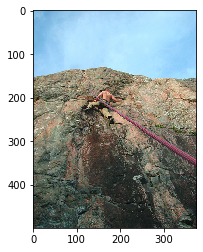

In [20]:

test_img_dir = 'data/Flickr_Data/Flickr_Data/Images/872622575_ba1d3632cc.jpg'

#uncomment to load a model with custom weights
model = load_model(test_model_dir)

#pre-processing test image
test = test_img(test_img_dir)

#loading and plotting test image
img = mpimg.imread(test_img_dir)
plt.imshow(img)

#printing the generated caption
print(greedySearch(test, model))